<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/root_finding/MultipleRoots_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import time
from functools import partial
import numpy as np

# Utility

look into using vmap instead of repeat and some of these other weird processes

In [195]:
@jax.jit
def signDistance(p):
  return jnp.linalg.norm(p,ord=2,axis=2,keepdims=False) - 1 # unit sphere

In [196]:
import numpy.core.numeric as _nx

def _make_along_axis_idx(arr_shape, indices, axis):
    # compute dimensions to iterate over
    if not _nx.issubdtype(indices.dtype, _nx.integer):
        raise IndexError("`indices` must be an integer array")
    if len(arr_shape) != indices.ndim:
        raise ValueError("`indices` and `arr` must have the same number of dimensions")
    shape_ones = (1,) * indices.ndim
    dest_dims = list(range(axis)) + [None] + list(range(axis + 1, indices.ndim))

    # build a fancy index, consisting of orthogonal aranges, with the
    # requested index inserted at the right location
    fancy_index = []
    for dim, n in zip(dest_dims, arr_shape):
        if dim is None:
            fancy_index.append(indices)
        else:
            ind_shape = shape_ones[:dim] + (-1,) + shape_ones[dim + 1 :]
            fancy_index.append(_nx.arange(n).reshape(ind_shape))

    return tuple(fancy_index)

def custom_put_along_axis(arr, indices, values, axis):
    """
    Parameters
    ----------
    arr : ndarray (Ni..., M, Nk...)
        Destination array.
    indices : ndarray (Ni..., J, Nk...)
        Indices to change along each 1d slice of `arr`. This must match the
        dimension of arr, but dimensions in Ni and Nj may be 1 to broadcast
        against `arr`.
    values : array_like (Ni..., J, Nk...)
        values to insert at those indices. Its shape and dimension are
        broadcast to match that of `indices`.
    axis : int
        The axis to take 1d slices along. If axis is None, the destination
        array is treated as if a flattened 1d view had been created of it.

    """

    # normalize inputs
    if axis is None:
        arr = arr.flat
        axis = 0
        arr_shape = (len(arr),)  # flatiter has no .shape
    else:
        # axis = normalize_axis_index(axis, arr.ndim)
        arr_shape = arr.shape

    # use the fancy index
    arr = arr.at[tuple(_make_along_axis_idx(arr_shape, indices, axis))].set(values)
    return arr

# Root Finding

In [197]:
@jax.jit
def bisection(p0, p1, rootSteps, dir):
  current = jnp.zeros((1, jnp.size(p0, 1)))

  def bisectionStep(i, current):
    next = current + jnp.power(0.5, i+1)
    dist1 = signDistance(p0 + dir * next[:,:,jnp.newaxis] * (p1 - p0))
    dist2 = signDistance(p0 + dir * current[:,:,jnp.newaxis] * (p1 - p0))
    return jnp.where(dist1 * dist2 > 0, next, current)

  current = lax.fori_loop(0, rootSteps, bisectionStep, current)
  
  return p0 + dir * current[:,:,jnp.newaxis] * (p1 - p0)

In [198]:
@partial(jax.jit, static_argnames=['uni_cuts', 'quad_cuts'])
def createQuadrature(uni_cuts, quad_cuts, p0, p1):
  lb = jnp.zeros(len(p0))
  ub = jnp.ones(len(p1))
  t0 = jnp.linspace(lb, ub, uni_cuts, axis=0)

  v0 = jnp.abs(signDistance(p0 + t0[:,:,jnp.newaxis] * (p1 - p0)))

  # quad_cuts should be greater than or equal to uni_cuts? not true?
  
  # smart variation
  uni_space = (ub - lb) / (uni_cuts - 1)
  threshold = jnp.linalg.norm(p1 - p0, ord=2, axis=1) / (2 * (uni_cuts - 1))
  n_close = jnp.count_nonzero(v0 < threshold, axis=0)
  
  spacing_amount = ((quad_cuts - uni_cuts) // n_close).astype(int) + 1
  spacing_value = uni_space / (spacing_amount)

  h = jnp.where(v0 < threshold, spacing_amount, 1)
  lol = jnp.where(v0 < threshold, spacing_value, uni_space)

  extra = quad_cuts % (n_close * spacing_amount + uni_cuts - n_close)
  h = h.at[-1].add(extra)

  lol2 = jnp.ravel(lol, order='F')
  h2 = jnp.ravel(h, order='F')
  xd = jnp.repeat(lol2, h2, total_repeat_length=quad_cuts * len(lb))
  xd = jnp.reshape(xd, (quad_cuts, len(lb)), order='F')
  xd = jnp.cumsum(xd, axis=0)
  xd -= uni_space / 2
  #xd += lb

  return xd

In [199]:
@jax.jit
def rootIsolate(key, quadrature, p0, p1):
  # in quadrature find the index of the value closest to 0.5
  # because we don't want to pick where we started
  idx = jnp.argmin(jnp.abs(quadrature - 0.5), axis=0, keepdims=True)

  # find the roots
  v = signDistance(p0 + quadrature[:,:,jnp.newaxis] * (p1 - p0))
  v = jnp.where(v > 0, 1, -1)
  roots = v[:-1] + v[1:]

  # fuck... np.put_along_axis is not implemented in jax yet
  roots = custom_put_along_axis(roots, idx, 99, axis=0)

  # check how many roots
  n_zeros = jnp.count_nonzero(roots == 0, axis=0)
  print("number of roots found (not including starting point):", n_zeros)

  # randomly pick a root
  minvals = jnp.zeros(jnp.size(quadrature, 1))
  random_indices = jrandom.randint(key, (1,jnp.size(quadrature, 1)), minval=minvals, maxval=n_zeros)

  # can speed this up by using a single for loop instead of: argsort + take_along_axis + custom_put_along_axis ?
  roots = jnp.where(roots == 0, 0, 1)
  all_root_indices = jnp.argsort(roots, axis=0)
  root_indices = jnp.take_along_axis(all_root_indices, random_indices, axis=0)

  lb = jnp.take_along_axis(quadrature, root_indices, axis=0)
  ub = jnp.take_along_axis(quadrature, root_indices+1, axis=0)
  
  # return the roots interval
  return lb, ub

In [200]:
%%time
key = jrandom.PRNGKey(int(time.time()))

uni_cuts = 10
quad_cuts = 20
p0 = jnp.array([[0, -1, 0], [1, 0, 0]]) # [samples, dimensions]
p1 = jnp.array([[2, 2, 2], [-2, 0, 0]])

p0 = 2*p0 - p1

# must always have more uni_cuts then there are roots
quadrature_t = createQuadrature(uni_cuts, quad_cuts, p0, p1)
t1, t2 = rootIsolate(key, quadrature_t, p0, p1)
root = bisection(p0 + t1[:,:,jnp.newaxis] * (p1 - p0),
                 p0 + t2[:,:,jnp.newaxis] * (p1 - p0),
                 10, dir=1)

# use "t, t2, dir" to find the sign of the normal
print("-------------------------------------------")
print('root:', root)
print('signDistance(root):', signDistance(root))

number of roots found (not including starting point): Traced<ShapedArray(int32[2])>with<DynamicJaxprTrace(level=0/1)>
-------------------------------------------
root: [[[-1.0850688e-04 -1.0001627e+00 -1.0850688e-04]
  [-9.9999952e-01  0.0000000e+00  0.0000000e+00]]]
signDistance(root): [[ 1.6272068e-04 -4.7683716e-07]]
CPU times: user 1.27 s, sys: 21.8 ms, total: 1.29 s
Wall time: 1.3 s


# Graphing

"\nt0 = jnp.linspace(p0[sample], p1[sample], uni_cuts)\nv0 = jnp.abs(signDistance(t0))\nthreshold = (p1[sample] - p0[sample]) / (uni_cuts - 1)\nplt.scatter(t0, v0, c='y')\nplt.axhline(threshold / 2, linestyle='-')\nfor t in t0:\n  plt.axvline(t, linestyle='-')\n"

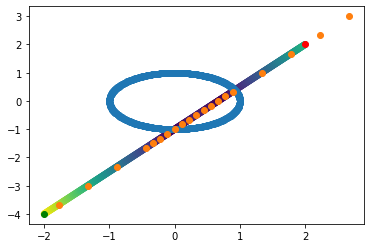

In [201]:
sample = 0
t = jnp.linspace(p0, p1, 500, axis=0)
thing = jnp.abs(signDistance(t))
plt.scatter(t[:,sample,0], t[:,sample,1], c=thing[:,sample])

thitohars = jnp.linspace(0, 2*jnp.pi, 500)
plt.scatter(jnp.cos(thitohars), jnp.sin(thitohars))


quadrature = p0 + quadrature_t[:,:,jnp.newaxis] * (p1 - p0)
plt.scatter(quadrature[:,sample,0], quadrature[:,sample,1])
plt.scatter(p0[sample, 0], p0[sample, 1], c='g')
plt.scatter(p1[sample, 0], p1[sample, 1], c='r')

'''
t0 = jnp.linspace(p0[sample], p1[sample], uni_cuts)
v0 = jnp.abs(signDistance(t0))
threshold = (p1[sample] - p0[sample]) / (uni_cuts - 1)
plt.scatter(t0, v0, c='y')
plt.axhline(threshold / 2, linestyle='-')
for t in t0:
  plt.axvline(t, linestyle='-')
'''